<a href="https://colab.research.google.com/github/sggsfhydhughjhf/AutoML/blob/master/internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter


### Data

In [ ]:
input = pd.read_excel("/content/Input.xlsx")
input.head()

,URL_ID,URL
0,123.0,https://insights.blackcoffer.com/rise-of-telem...
1,321.0,https://insights.blackcoffer.com/rise-of-e-hea...
2,2345.0,https://insights.blackcoffer.com/rise-of-e-hea...
3,4321.0,https://insights.blackcoffer.com/rise-of-telem...
4,432.0,https://insights.blackcoffer.com/rise-of-telem...


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['URL_ID'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['URL_ID'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_2, *['URL'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_3, *['URL_ID', 'URL'], **{'inner': 'stick'})
chart

In [ ]:
input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   URL_ID  114 non-null    float64
 1   URL     114 non-null    object 
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [ ]:
import re
from textblob import TextBlob
from textstat import textstat

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Try different encodings until the file can be read without errors
encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1']

for encoding in encodings_to_try:
    try:
        with open('/content/StopWords_Currencies.txt', 'r', encoding=encoding) as f:
            custom_stopwords = set([line.strip() for line in f.readlines()])
        break  # Stop trying encodings once successful
    except UnicodeDecodeError:
        pass  # Continue to the next encoding

if 'custom_stopwords' not in locals():
    print("Unable to read the file with any of the tried encodings.")
else:
    print("Custom stopwords loaded successfully.")

Custom stopwords loaded successfully.


In [ ]:
# Load custom stopwords from different files
stopwords_files = [
    'StopWords_Auditor.txt',
    'StopWords_Currencies.txt',
    'StopWords_DatesandNumbers.txt',
    'StopWords_Generic.txt',
    'StopWords_GenericLong.txt',
    'StopWords_Geographic.txt',
    'StopWords_Names.txt'
]

all_custom_stopwords = set()

for stopwords_file in stopwords_files:
    try:
        with open('/content/StopWords/' + stopwords_file, 'r', encoding='latin-1') as f:
            custom_stopwords = set([line.strip() for line in f.readlines()])
            all_custom_stopwords.update(custom_stopwords)
    except FileNotFoundError:
        print(f"File {stopwords_file} not found.")

# Combine NLTK stopwords with all custom stopwords
all_stopwords = stop_words.union(all_custom_stopwords)


In [ ]:
# Load positive and negative lexicons
positive_lexicon_path = '/content/positive-words.txt'
negative_lexicon_path = '/content/negative-words.txt'

with open(positive_lexicon_path, 'r',encoding='latin-1') as f:
    positive_lexicon = set([line.strip() for line in f.readlines()])

with open(negative_lexicon_path, 'r',encoding='latin-1') as f:
    negative_lexicon = set([line.strip() for line in f.readlines()])


In [ ]:
# Initialize a dictionary to store analysis results
analysis_results = []

# Iterate through each row in the DataFrame
for index, row in input.iterrows():
    url_id = row['URL_ID']
    url = row['URL']

    # Extract text from the URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    article_text = " ".join([p.get_text() for p in soup.find_all('p')])

    # Clean text and perform analysis
    cleaned_tokens = [word.lower() for word in word_tokenize(article_text) if word.isalnum() and word not in custom_stopwords]
    cleaned_text = " ".join(cleaned_tokens)

    # Sentiment analysis
    blob = TextBlob(cleaned_text)
    positive_score = sum([1 for word in cleaned_tokens if word in positive_lexicon])
    negative_score = sum([1 for word in cleaned_tokens if word in negative_lexicon])
    polarity_score = (positive_score - negative_score) / (positive_score + negative_score + 0.000001)
    subjectivity_score = blob.sentiment.subjectivity

    # Readability analysis
    avg_sentence_length = textstat.lexicon_count(cleaned_text) / textstat.sentence_count(cleaned_text)
    percentage_complex_words = (textstat.difficult_words(cleaned_text) / textstat.lexicon_count(cleaned_text)) * 100  # Calculate percentage
    fog_index = 0.4 * (avg_sentence_length + percentage_complex_words)
    avg_words_per_sentence = textstat.lexicon_count(cleaned_text) / textstat.sentence_count(cleaned_text)
    complex_word_count = textstat.difficult_words(cleaned_text)
    word_count = textstat.lexicon_count(cleaned_text)
    syllable_per_word = textstat.syllable_count(cleaned_text) / word_count
    personal_pronouns = len(re.findall(r'\b(?:i|we|my|ours|us)\b', cleaned_text, flags=re.IGNORECASE))
    avg_word_length = sum(len(word) for word in cleaned_tokens) / word_count


    # Store results in a dictionary
    result = {
        'URL_ID': url_id,
        'Positive_Score': positive_score,
        'Negative_Score': negative_score,
        'Polarity_Score': polarity_score,
        'Subjectivity_Score': subjectivity_score,
        'Avg_Sentence_Length': avg_sentence_length,
        'Percentage_Complex_Words': percentage_complex_words,
        'Fog_Index': fog_index,
        'Avg_Words_Per_Sentence': avg_words_per_sentence,
        'Complex_Word_Count': complex_word_count,
        'Word_Count': word_count,
        'Syllable_Per_Word': syllable_per_word,
        'Personal_Pronouns': personal_pronouns,
        'Avg_Word_Length': avg_word_length
    }
    analysis_results.append(result)

In [ ]:
from wordcloud import WordCloud

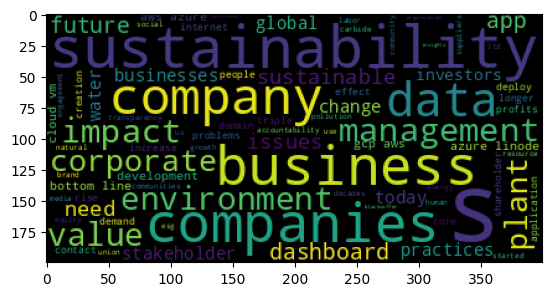

In [ ]:
wc = WordCloud()
result = wc.generate_from_text(cleaned_text)
plt.imshow(result)

In [ ]:
from nltk import FreqDist

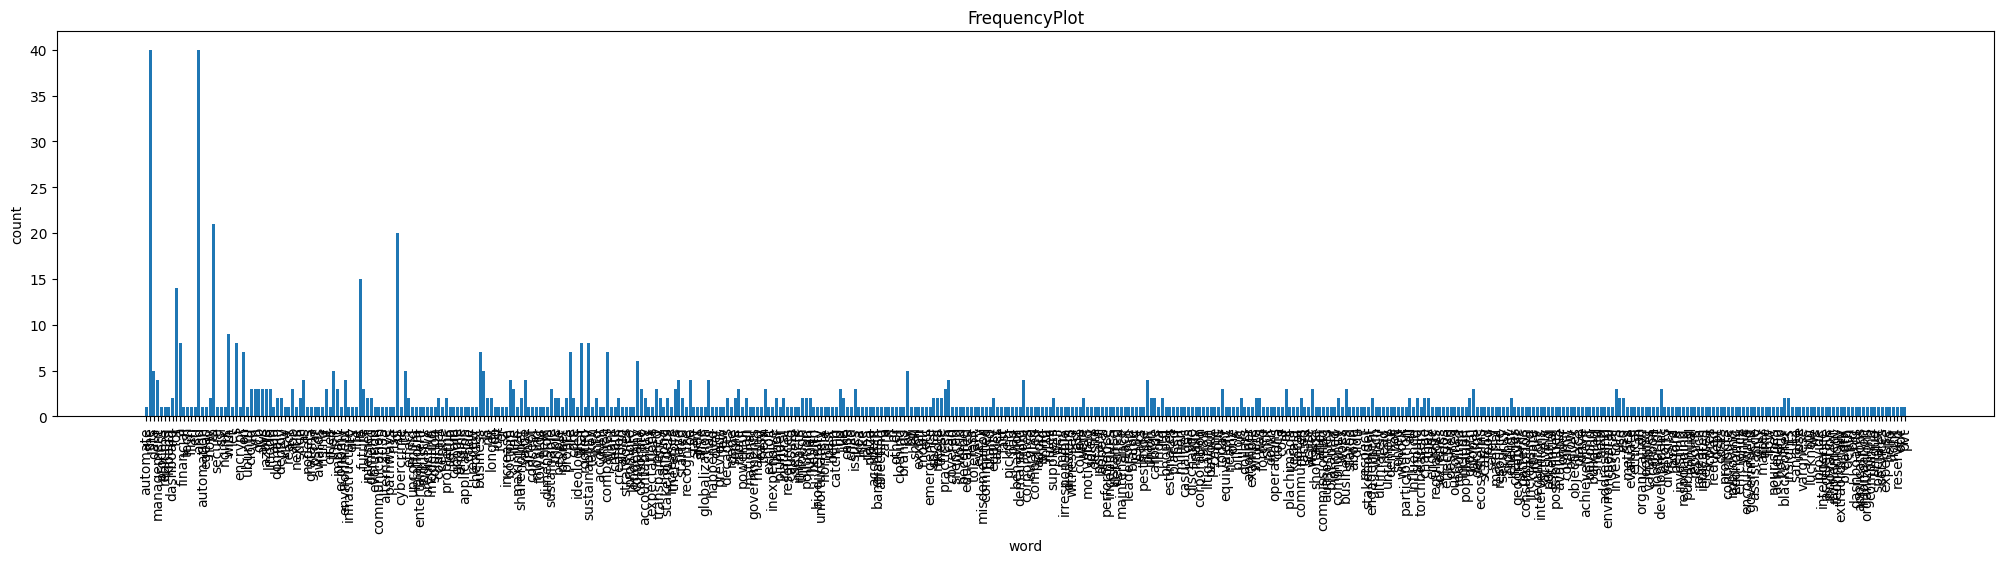

In [ ]:
x= FreqDist(cleaned_tokens).keys()
y= FreqDist(cleaned_tokens).values()
plt.figure(figsize=(25,5))
plt.bar(x,y)
plt.xlabel("word")
plt.xticks(rotation=90)
plt.ylabel("count")
plt.title("FrequencyPlot")
plt.show()

In [ ]:
output_df = pd.DataFrame(analysis_results)

In [ ]:
output_df

,URL_ID,Positive_Score,Negative_Score,Polarity_Score,Subjectivity_Score,Avg_Sentence_Length,Percentage_Complex_Words,Fog_Index,Avg_Words_Per_Sentence,Complex_Word_Count,Word_Count,Syllable_Per_Word,Personal_Pronouns,Avg_Word_Length
0,123.0,94,28,0.540984,0.431785,1835.0,13.623978,739.449591,1835.0,250,1835,1.643597,4,5.530245
1,321.0,47,17,0.468750,0.572909,773.0,22.121604,318.048642,773.0,171,773,1.750323,5,5.416559
2,2345.0,31,31,0.000000,0.446419,1227.0,21.189894,499.275958,1227.0,260,1227,1.657702,5,5.233089
3,4321.0,49,31,0.225000,0.381668,1380.0,23.478261,561.391304,1380.0,324,1380,1.667391,9,5.412319
4,432.0,49,31,0.225000,0.381668,1380.0,23.478261,561.391304,1380.0,324,1380,1.667391,9,5.412319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,50921.0,14,11,0.120000,0.396201,641.0,26.209048,266.883619,641.0,168,641,1.627145,3,5.135725
110,51382.8,33,69,-0.352941,0.374514,1855.0,17.628032,749.051213,1855.0,327,1855,1.629650,5,5.135310
111,51844.6,101,36,0.474453,0.444518,1827.0,22.167488,739.666995,1827.0,405,1827,1.640394,2,5.143952
112,52306.4,37,25,0.193548,0.423224,1517.0,17.996045,613.998418,1517.0,273,1517,1.561635,10,4.959789


In [ ]:
output_df.to_csv('output.csv', index=False)

In [ ]:
output_df.to_excel("output.xlsx",index=False)